In [45]:
import numpy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import sys
import numpy as np
import yaml
from typing import Dict
from tqdm import tqdm

from adase.utils.pandas import read_df
from adase.utils.files import (directory_path,
                                get_raw_file,
                                get_all_files)
from adase.utils.pandas import write_df, read_df

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

In [5]:
def config(path) -> Dict:
    with open("{}config.yml".format(path), 'r') as ymlfile:
            cfg = yaml.load(ymlfile)
    return cfg

def download_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    for file in tqdm(cfg.get('makedataset').get('files')):
        get_raw_file(raw_path, file)

def load_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    
    dict_data: Dict = dict()

    for key, val in read_df(get_all_files(raw_path)).items():

        df_tmp = val.rename(columns={
                    'item': 'item_code',
                    'quantity_ecd': 'quantity',
                    'parent_item': 'parent_item_code',
                    'parent_quantity_ecd': 'parent_quantity'
                })

        if 'rpd' in df_tmp:
            first_element = sorted(df_tmp['rpd'].unique())[0]
            if first_element/1 != 1:
                df_tmp['rpd'] = df_tmp['rpd'] - (first_element-1)

        dict_data.update({key: df_tmp})
                
    return dict_data

cfg = config('../')
download_dataset(cfg)
data_dicts = load_dataset(cfg)

100%|██████████| 9/9 [00:00<00:00, 80.47it/s]


In [6]:
data_series = data_dicts.get('demand_out_encoded_stage_3')\
.set_index(['item_code', 'rpd','future_flag'])\
.sort_index().unstack("rpd", fill_value=0).fillna(0).values

mu, sigma = 0, 0.1 
#[:600]
#data = np.log1p(
data = np.log1p(data_series[:]) + np.abs(np.random.normal(mu, sigma, size=data_series.shape))

In [179]:
def plot_data(ks, X_train, y_pred, sz, n_clusters=3, centroid=False):
    
    plt.figure(figsize=(12,25))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            #, alpha=.2
            plt.plot(xx.ravel(), "k-")
            #,
        if centroid:
            plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    plt.tight_layout()
    plt.show()
    
def split_train_test(X, y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
def normalize_data(data):
    numpy.random.shuffle(data)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(data_series)
    sz = X_train.shape[1]
    
    return X_train, sz

def k_shape(data_series_normalized, n_clusters=3, verbose=True, seed=0):

    # Euclidean k-means
    ks = KShape(n_clusters=n_clusters, verbose=verbose, random_state=seed)
    
    return ks, ks.fit_predict(X_train)

def compute_scores(ks, X_train, y_pred, centroid=False):

    scores = []
    for yi in range(ks.n_clusters):
        tp_list = []
        for xx in X_train[y_pred == yi]:
            
            if centroid:
                predicted = ks.cluster_centers_[yi].ravel()
                actual = xx.ravel()
                score = adjusted_rand_score(actual, predicted)
                scores.append(score)
                
            else:
                predicted = xx.ravel()
                tp_list.append(predicted)
        
        if not centroid:
            half = len(tp_list)//2
            first_half = tp_list[:half]
            second_half = tp_list[half:]
            
            for i in np.arange(half):
                score = adjusted_rand_score(first_half[i], second_half[i])
                scores.append(score)
                            
            
    return scores
    #print('score: {0} -- actual: {1} -- predicted: {2}'.format(score, actual, predicted))

In [117]:
X_train, sz = normalize_data(data_series[:500])
ks, y_pred = k_shape(X_train, n_clusters=20)
#plot_data(X_train, y_pred, sz, 10)

0.053 --> 0.041 --> 0.037 --> 0.036 --> 0.034 --> 0.033 --> 0.033 --> 0.032 --> 0.033 --> 


In [118]:
scores = compute_scores(ks, X_train, y_pred)

In [122]:
np.mean(scores)

0.002279132592922573

{'whiskers': [<matplotlib.lines.Line2D at 0x7f29472c14a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f29472c1ba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f29472c1320>],
 'medians': [<matplotlib.lines.Line2D at 0x7f29472df2e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f29472df668>],
 'means': []}

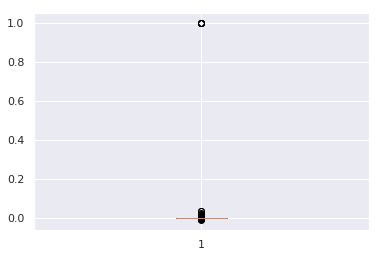

In [120]:
plt.boxplot(scores)

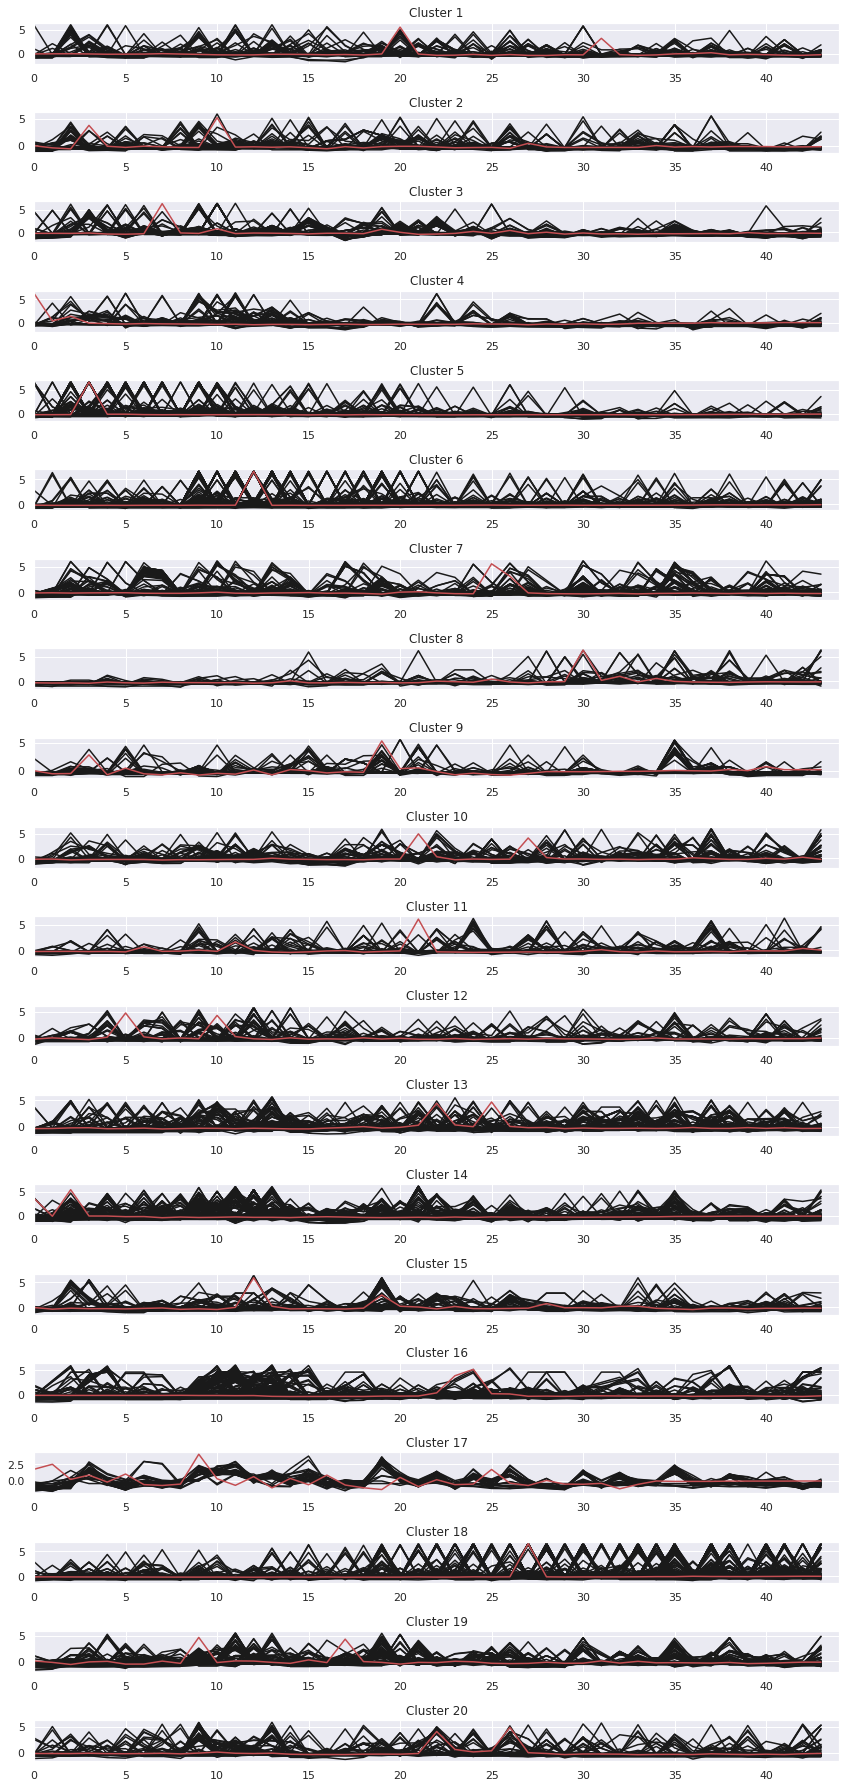

In [121]:
plot_data(ks, X_train, y_pred, sz, ks.n_clusters)

Init 1
5207.534 --> 5145.669 --> 5140.035 --> 5136.769 --> 5125.647 --> 5122.740 --> 5121.768 --> 5118.568 --> 5117.273 --> 5116.658 --> 5114.732 --> 5113.697 --> 5112.697 --> 5112.378 --> 5112.439 --> 5112.439 --> 
Init 2
5201.614 --> 5120.363 --> 5100.213 --> 5099.850 --> 5099.782 --> 5099.967 --> 5099.368 --> 5099.245 --> 5099.028 --> 5098.707 --> 5098.384 --> 5098.276 --> 5098.276 --> 
Init 3
5202.507 --> 5110.495 --> 5106.021 --> 5104.954 --> 5104.766 --> 5104.766 --> 
Init 4
5204.879 --> 5139.729 --> 5126.493 --> 5105.431 --> 5101.463 --> 5101.025 --> 5100.892 --> 5100.892 --> 
Init 5
5205.972 --> 5134.032 --> 5117.638 --> 5117.440 --> 5117.297 --> 5116.685 --> 5116.578 --> 5116.475 --> 5116.151 --> 5115.717 --> 5115.719 --> 5115.719 --> 
Init 6
5206.914 --> 5150.778 --> 5128.803 --> 5120.012 --> 5116.133 --> 5112.921 --> 5111.426 --> 5110.571 --> 5110.459 --> 5108.727 --> 5107.503 --> 5107.072 --> 5106.439 --> 5106.156 --> 5106.079 --> 5106.079 --> 
Init 7
5206.276 --> 5148.818 

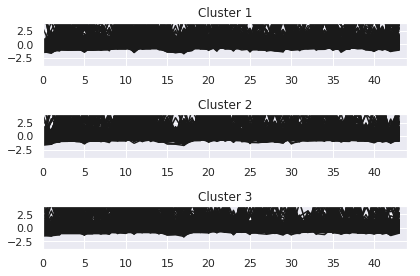

In [124]:
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak, cdist_gak
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#seed = 0
#numpy.random.seed(seed)
#X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
#X_train = X_train[y_train < 4]  # Keep first 3 classes
#numpy.random.shuffle(X_train)
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])  # Keep only 50 time series
sz = X_train[:50].shape[1]

gak_km = GlobalAlignmentKernelKMeans(n_clusters=3, sigma=sigma_gak(X_train[:50]), n_init=20, verbose=True, random_state=seed)
y_pred = gak_km.fit_predict(X_train)



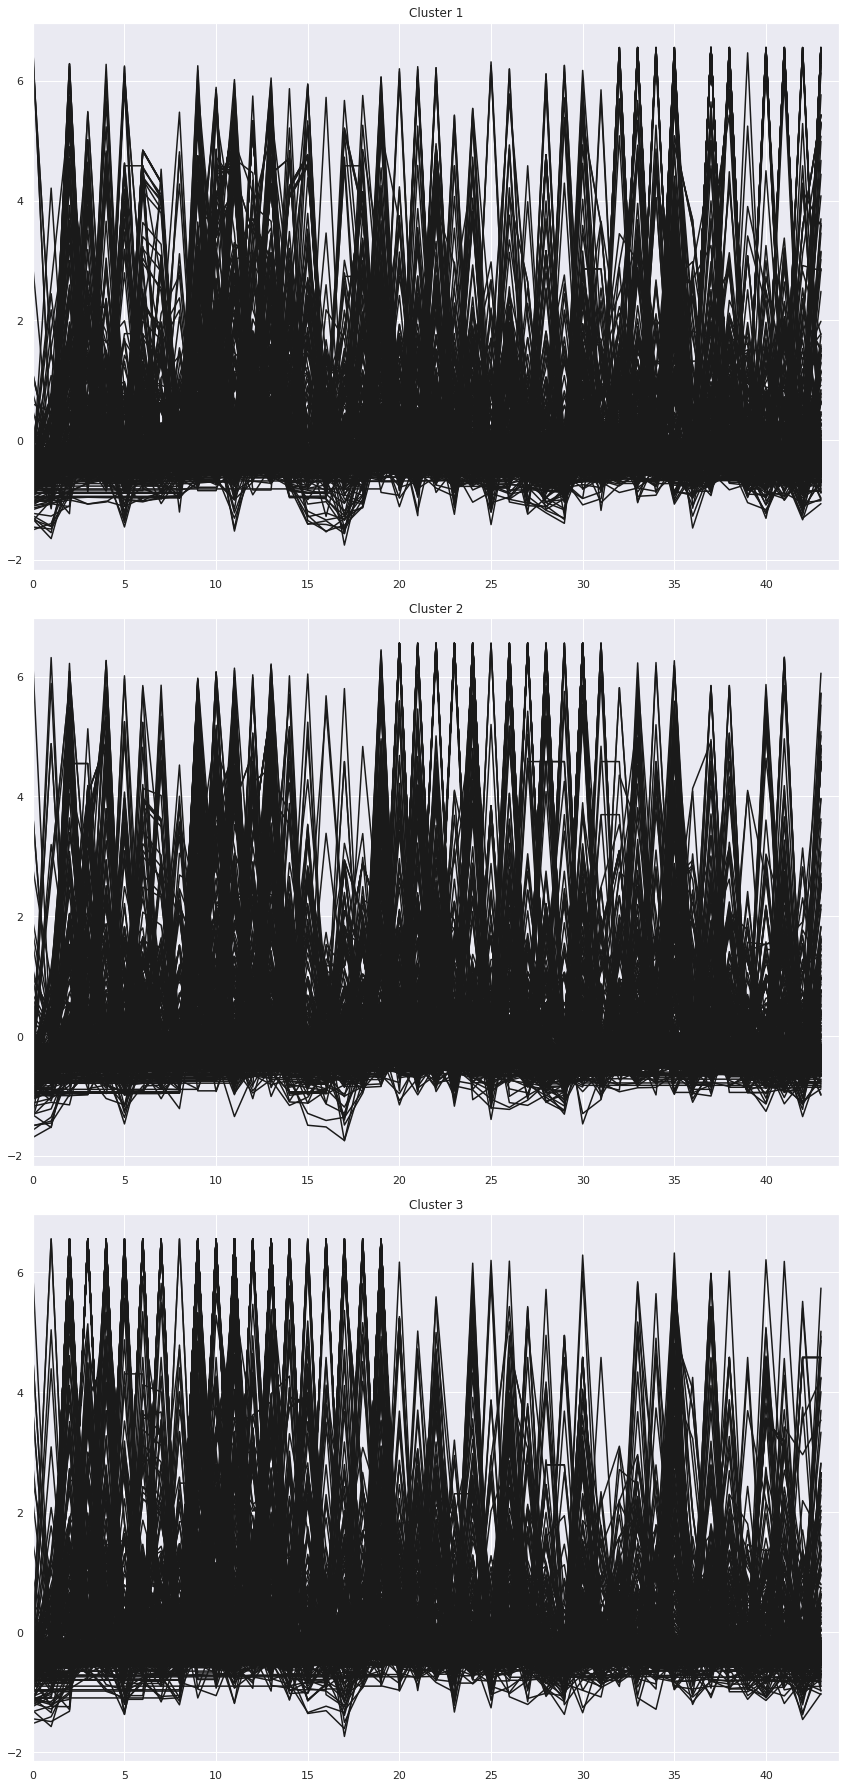

In [151]:
plot_data(gak_km, X_train, y_pred, sz, gak_km.n_clusters)

In [180]:
scores = compute_scores(gak_km, X_train, y_pred, centroid=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2947c5f2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2947c5f9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2947c5f128>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2947c7b0f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2947c7b470>],
 'means': []}

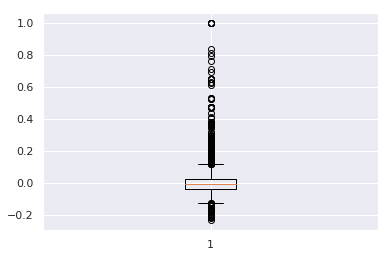

In [182]:
plt.boxplot(scores)

In [174]:
tp_list = []
for xx in X_train[y_pred == 0]:
    tp_list.append(xx.ravel())

In [178]:
half = len(tp_list)//2
first_half = tp_list[:half]
second_half = tp_list[half:]

[array([-0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857, -0.15249857, -0.15249857,
        -0.15249857, -0.15249857, -0.15249857,  6.55743852]),
 array([-0.21786595, -0.21786595, -0.21786595, -0.21786595, -0.21786595,
        -0.21786595,  4.84146559,  4.30890437, -0.21786595, -0.21786595,
        -0.21786595, -0.21786595, -0.21786595, -0.21786595, -0.21786595,
        -0.21786595, -0.21786595, -0.21786595, -0.21786595, -0.21786595,
        -0.21786595, -0.21786595, -0.21786595, -0.21786595, -0

In [ ]:
plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()